In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm,

import seaborn as sns; sns.set()

from pandas.core import datetools
%matplotlib inline

import pickle


Using TensorFlow backend.


# Data Acquisition
The following code imports and validates the LendingClub data.

In [2]:
# Imports loan data

df = pd.DataFrame()
basepath='./Source Data/Loan Data/'
files = os.listdir(basepath)
csvs = []

for file in files:
    if re.match('.*csv$',file):
        csvs += [file]

try:
    df=pickle.load(open('full_data.p', 'rb'))
    print('Read from pickle')
except:
    dates = [
        'next_pymnt_d',
        'hardship_start_date',
        'hardship_end_date',
        'payment_plan_start_date',
        'earliest_cr_line',
        'issue_d',
        'debt_settlement_flag_date',
        'last_pymnt_d'

    ]
    cols = df.dtypes
    for csv in csvs:
        path = basepath + csv
        print("Reading",path)
        tdf = pd.read_csv(path,header=1,parse_dates=dates,low_memory=False)
        df=df.append(tdf)
    df.reset_index(inplace=True) # This will help with joining back data if necessary.
    # Convert dates to datetime
    #df['issue_d'] = pd.to_datetime(df['issue_d'])
    #df['debt_settlement_flag_date'] = pd.to_datetime(df['debt_settlement_flag_date'])
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
    
    #determine age of credit line prior to loan issue and convert to integer
    # days of credit history
    df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days
    
    # convert issue_d to a year to consider economic conditions
    #SHOULD WE GO TO QUARTERS?
    #df['issue_d'] = df['issue_d'].dt.year
    
    df['duration'] = (df['last_pymnt_d'] - df['issue_d']).dt.days / 30
    pickle.dump( df, open( "full_data.p", "wb" ) )

print(df.shape)

Read from pickle
(1873317, 154)


In [3]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

In [4]:
# Convert dates to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

#determine age of credit line prior to loan issue and convert to integer
# days of credit history
df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days

# convert issue_d to a year to consider economic conditions
#SHOULD WE GO TO QUARTERS?
df['issue_d'] = df['issue_d'].dt.year

In [5]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data

mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2

reduced_df.drop(columns=['fico_range_low','fico_range_high'],inplace=True)
print(reduced_df.shape)

(1020552, 69)


In [6]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

grade_map={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7}
reduced_df['grade']=reduced_df['grade'].replace(pd.Series(grade_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x:
                                                        x[:-1] if isinstance(x, str) else np.nan).astype(float)

reduced_df['earliest_cr_line']=reduced_df['earliest_cr_line'].apply(lambda x:
                                                        0.0 if np.isnan(x) else x)

reduced_df.drop(columns=['emp_title'],inplace=True)

print(reduced_df.shape)

(1020552, 68)


In [7]:
# Consolidated where logical
reduced_df['purpose'].replace('credit_card','debt_consolidation',inplace=True)
reduced_df['purpose'].replace('educational','other',inplace=True)
reduced_df['purpose'].replace('wedding','major_purchase',inplace=True)
reduced_df['purpose'].replace('vacation','major_purchase',inplace=True)
reduced_df['purpose'].replace('moving','house',inplace=True)
reduced_df['purpose'].replace('home_improvement ','house',inplace=True)
reduced_df['purpose'].replace('renewable_energy ','house',inplace=True)

In [8]:
seta=set(reduced_df.columns)


# 8/8 consolidated purpose

reduced_df=pd.get_dummies(data=reduced_df,columns=['application_type','term',
                                                   'verification_status','purpose'],
                          drop_first=True)

# 8/8 removed 'home_ownership
reduced_df['home_ownership'] = np.where(reduced_df['home_ownership']=='OWN',1,0)

setb=set(reduced_df.columns)
print(setb-seta)
print(reduced_df.shape)

{'purpose_small_business', 'purpose_home_improvement', 'purpose_house', 'verification_status_Verified', 'purpose_debt_consolidation', 'term_ 60 months', 'purpose_renewable_energy', 'verification_status_Source Verified', 'application_type_Joint App', 'purpose_major_purchase', 'purpose_other', 'purpose_medical'}
(1020552, 76)


In [9]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=25

In [10]:
nonnan_df=reduced_df.drop(columns=order_has_data[0:19])
print(nonnan_df.shape)

(1020552, 57)


In [11]:
print(len(reduced_df.dropna()),len(nonnan_df.dropna()))
nonnan_df=nonnan_df.dropna()
print(nonnan_df.shape)

n_options = {}
for column in nonnan_df.columns:
    n_options[column] = len(nonnan_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])


191 890451
(890451, 57)


In [12]:
revolving = [
    'bc_open_to_buy',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'revol_bal',
    'revol_util',
    'total_rev_hi_lim',
    'tot_hi_cred_lim',
    'num_il_tl',
    'open_acc',
    'num_bc_tl',
    'num_sats',
    'num_op_rev_tl',
    'num_bc_sats',
    'mo_sin_old_rev_tl_op',
    'total_il_high_credit_limit'
]

to_remove = revolving.copy()
to_remove += ['grade'] # Extra code to drop grade

# Additional factors to remove
if 'installment' not in to_remove:
    to_remove += ['installment']
to_remove += ['total_pymnt','loan_amnt']
   
    
features = list(set(nonnan_df.columns) - set(to_remove))

nonnan_df['percent_of_income'] = nonnan_df['installment']*12/nonnan_df['annual_inc']
nonnan_df['percent_of_income'].describe()

count    890451.000000
mean          0.078961
std           0.058131
min           0.000123
25%           0.047093
50%           0.072570
75%           0.104865
max          31.792800
Name: percent_of_income, dtype: float64

# Let's work with training and test sets
In this section, we compile and test our final model. It incorporates predictors for continuous variables such as regressions after incorporating our best classification models.

In [13]:
# Loads and combines the 

# Loads classification
cat_preds = pickle.load(open("pred_for_final.pkl",'rb'))

df = pd.concat([nonnan_df,cat_preds],axis=1).dropna()
df.head()


annual_inc  bc_open_to_buy  chargeoff_within_12_mths  \
42538     32760.0          2689.0                       0.0   
42539    325000.0         13901.0                       0.0   
42540     40000.0          1428.0                       0.0   
42541     63000.0          2969.0                       0.0   
42542    100000.0          4822.0                       0.0   

       collections_12_mths_ex_med  delinq_2yrs    dti  emp_length  grade  \
42538                         0.0          0.0  27.06         4.0    5.0   
42539                         0.0          0.0  18.55         5.0    1.0   
42540                         0.0          0.0  16.94        10.0    2.0   
42541                         0.0          0.0  16.51         2.0    1.0   
42542                         0.0          0.0  22.18        10.0    2.0   

       home_ownership  inq_last_6mths ...   purpose_major_purchase  \
42538             0.0             0.0 ...                      0.0   
42539             0.0             1.0 ...                      0.0   
42540             0.0             0.0 ...                      0.0   
42541             0.0             0.0 ...                      0.0   
42542             0.0             0.0 ...                      0.0   

       purpose_medical  purpose_other  purpose_renewable_energy  \
42538              0.0            0.0                       0.0   
42539              0.0            0.0                       0.0   
42540              0.0            0.0                       0.0   
42541              0.0            0.0                       0.0   
42542              0.0            0.0                       0.0   

       purpose_small_business  percent_of_income   DT   RF  Log  Ada  
42538                     0.0           0.118513  0.0  0.0  1.0  0.0  
42539                     0.0           0.032216  1.0  1.0  1.0  1.0  
42540                     0.0           0.122220  1.0  1.0  1.0  1.0  
42541                     0.0           0.090724  1.0  1.0  1.0  1.0  
42542                     0.0           0.097776  1.0  1.0  1.0  1.0  

[5 rows x 62 columns]

In [14]:
y=df['total_pymnt']/(df['installment']*36 + df['installment']*df['term_ 60 months']*24)
print(features)
traintest_df=df[features]

X_train, X_test, y_train, y_test = train_test_split(
    traintest_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

Xscaler = StandardScaler()
Xscaler.fit_transform(X_train,X_test)

print(X_train.shape,X_test.shape)

['num_tl_op_past_12m', 'home_ownership', 'purpose_house', 'tax_liens', 'dti', 'total_bal_ex_mort', 'int_rate', 'application_type_Joint App', 'mort_acc', 'mths_since_recent_bc', 'earliest_cr_line', 'purpose_medical', 'percent_bc_gt_75', 'emp_length', 'total_bc_limit', 'num_accts_ever_120_pd', 'issue_d', 'annual_inc', 'pub_rec', 'verification_status_Verified', 'term_ 60 months', 'purpose_major_purchase', 'collections_12_mths_ex_med', 'inq_last_6mths', 'purpose_small_business', 'purpose_home_improvement', 'purpose_debt_consolidation', 'mo_sin_rcnt_rev_tl_op', 'delinq_2yrs', 'verification_status_Source Verified', 'purpose_renewable_energy', 'num_tl_90g_dpd_24m', 'tot_coll_amt', 'chargeoff_within_12_mths', 'purpose_other', 'fico_est', 'mo_sin_rcnt_tl', 'pub_rec_bankruptcies']
(705900, 38) (176475, 38)


In [15]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

-4.9747557436936685
[-3.72611385e-03  8.48061421e-04 -6.54276913e-03 -3.89736093e-03
 -1.57406971e-03  1.07324378e-07 -1.41145657e-02  9.71332390e-14
  5.10380288e-03  1.75642746e-04 -1.25310339e-04 -1.63470874e-02
 -1.44113459e-05  1.01214391e-03  5.55147735e-08  1.36130698e-03
  3.98446170e-03 -5.26164820e-09  3.81117149e-03 -1.07134402e-02
 -1.37817991e-01 -1.08155241e-02 -6.47743820e-03 -5.03624389e-03
 -3.89125643e-02 -6.87988816e-03 -4.40897520e-03 -6.16919067e-05
 -2.53372539e-03 -9.19560918e-03 -2.55866548e-02  5.46572211e-04
  2.29823015e-08 -1.09225394e-03  6.53817253e-04  1.20527825e-04
  9.09518109e-05 -1.78271107e-03]
The training set OLS regression R^2 score is: 0.237292
The test set OLS regression R^2 score is: 0.261977


In [16]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 100
intercept = -4.970195394763961
betas = [-3.72174290e-03  8.53514544e-04 -5.06050113e-03 -3.86839778e-03
 -1.57379709e-03  1.07194630e-07 -1.41251223e-02  0.00000000e+00
  5.10024302e-03  1.75556584e-04 -1.25306293e-04 -1.47357320e-02
 -1.42961562e-05  1.01122751e-03  5.51889257e-08  1.36119215e-03
  3.98165253e-03 -5.30143219e-09  3.78393404e-03 -1.07165878e-02
 -1.37661902e-01 -9.37144703e-03 -6.43141912e-03 -5.02942516e-03
 -3.69675481e-02 -5.48484691e-03 -3.03201767e-03 -6.16540380e-05
 -2.53165728e-03 -9.19987761e-03 -1.95795561e-02  5.43961431e-04
  2.30394552e-08 -1.07912531e-03  2.05906868e-03  1.20184725e-04
  9.11062674e-05 -1.75681052e-03], 
The training set Ridge regression R^2 score is: 0.237291
The test set Ridge regression R^2 score is: 0.261972


In [17]:
LCLRModel = LassoCV(alphas=lambdas, cv=kfold)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = 2.8772753654536327
betas = [-3.32039779e-03  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.55185509e-03  9.75448006e-08 -1.48229719e-02  0.00000000e+00
  4.61847323e-03  1.67540417e-04 -1.14540030e-04 -0.00000000e+00
 -0.00000000e+00  9.48772521e-04  2.64224196e-08  5.53884578e-04
  0.00000000e+00 -1.18209854e-08  0.00000000e+00 -6.04993888e-04
 -1.30452299e-01 -0.00000000e+00 -0.00000000e+00 -3.70259540e-03
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -4.25931416e-05
 -8.04195575e-04 -1.84018765e-04 -0.00000000e+00 -0.00000000e+00
  2.54569900e-08 -0.00000000e+00  0.00000000e+00  1.12155049e-04
  8.61619814e-05  0.00000000e+00], 
The training set Lasso regression R^2 score is: 0.236532
The test set Lasso regression R^2 score is: 0.261045


In [18]:
coef_df=pd.DataFrame(np.array([X_train.columns,
                               LCOLSModel.coef_,
                               LCRRModel.coef_,
                               LCLRModel.coef_]).T,columns=["feature","OLS","RR","LR"])

In [19]:
print(coef_df)

                                feature          OLS           RR           LR
0                    num_tl_op_past_12m  -0.00372611  -0.00372174   -0.0033204
1                        home_ownership  0.000848061  0.000853515            0
2                         purpose_house  -0.00654277   -0.0050605           -0
3                             tax_liens  -0.00389736   -0.0038684           -0
4                                   dti  -0.00157407   -0.0015738  -0.00155186
5                     total_bal_ex_mort  1.07324e-07  1.07195e-07  9.75448e-08
6                              int_rate   -0.0141146   -0.0141251    -0.014823
7            application_type_Joint App  9.71332e-14            0            0
8                              mort_acc    0.0051038   0.00510024   0.00461847
9                  mths_since_recent_bc  0.000175643  0.000175557   0.00016754
10                     earliest_cr_line  -0.00012531 -0.000125306  -0.00011454
11                      purpose_medical   -0.0163471

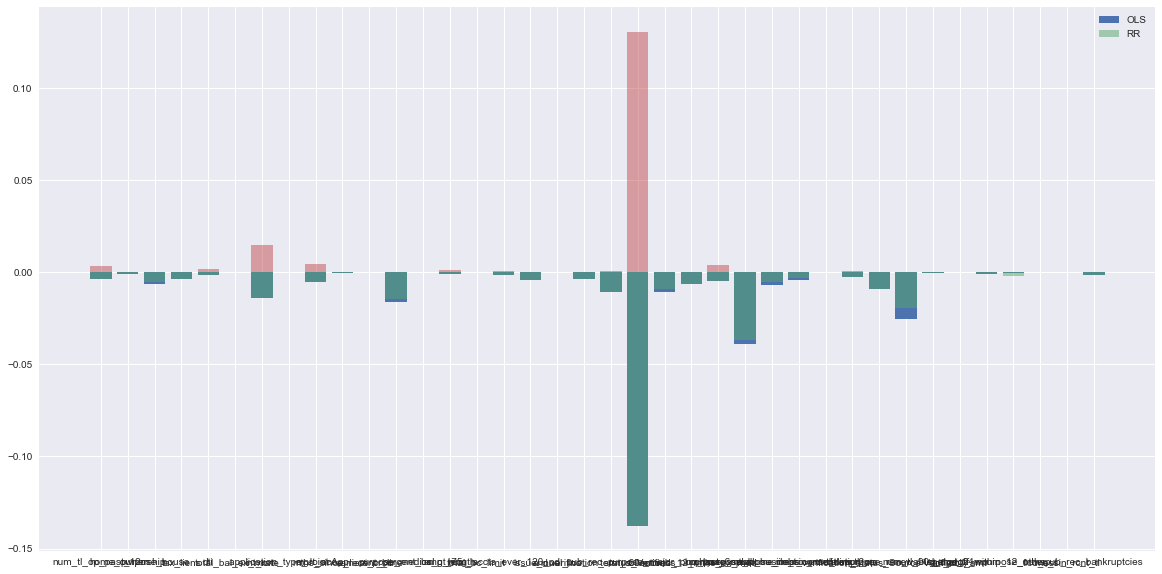

In [20]:
# your code here
plt.figure(figsize=(20,10))
plt.bar(coef_df["feature"],[-abs(x) for x in coef_df["OLS"].values],label='OLS',alpha=1.0)
plt.bar(coef_df["feature"],[-abs(x) for x in coef_df["RR"].values],label='RR',alpha=0.5)
plt.bar(coef_df["feature"],[abs(x) for x in coef_df["LR"].values],alpha=0.5)
plt.yscale("linear")

plt.legend()
plt.show()

In [21]:
#size = []
#avg_score = []
#sd_score = []
#for i in range(3,15):
#    s = i * 4
#    RF_model = RandomForestRegressor(s,n_jobs=4)
#    cv = cross_val_score(RF_model,X_train,y_train,cv=4)
#    size += [s]
#    avg_score +=  [np.average(cv)]
#    sd_score += [np.std(cv)]
#    print(i,'complete')
#    

In [22]:
#plt.plot(size,avg_score)
#bound = []
#for i in range(len(size)):
#    bound += [avg_score[i]+sd_score[i]]
#plt.plot(size,bound,c='orange')
#
#bound = []
#for i in range(len(size)):
#    bound += [avg_score[i]-sd_score[i]]
#plt.plot(size,bound,c='orange')
#plt.legend(['Average','$\mu\pm\sigma$'])
#plt.title('Cross validation of decision tree')
#plt.xlabel('Tree Depth')
#plt.ylabel('$R^2$ from cross validation')
#

I ran cross validation overnight and found that we see the ideal tree depth is approximately 50. Here is a single model with tree depth of 50. I did not have to run the code again when testing fully, but included the code I used to document our methods.

In [23]:
RF_model = RandomForestRegressor(50,n_jobs=4)
RF_final = RF_model.fit(X_train,y_train)
RFtrainR2 = r2_score(y_train,RF_final.predict(X_train))
RFtestR2 = r2_score(y_test,RF_final.predict(X_test))
print("The training set Random Forest regression R^2 score is: %f" % RFtrainR2)
print("The test set Random Forest regression R^2 score is: %f" % RFtestR2)

The training set Random Forest regression R^2 score is: 0.882680
The test set Random Forest regression R^2 score is: 0.244598


Our ridge outperforms the Random forest. I will show the diagnostics from the Ridge regression which we will use in the final submission.

Text(0,0.5,'$\\epsilon$')

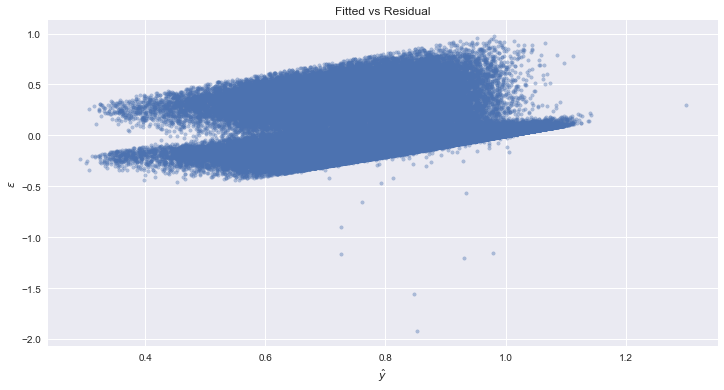

In [27]:
y_hat = LCRRModel.predict(X_test)
resids = y_hat - y_test

plt.figure(figsize=(12,6))
plt.scatter(y_hat,resids,marker='.',alpha=.4)
plt.title("Fitted vs Residual")
plt.xlabel('$\hat{y}$')
plt.ylabel('$\epsilon$')